# Calibrating Photodide with Air Measurement

Here we will construct a procedure for calibrating Derp by measuring air. The air measurement is done because it is the closest thing to a "well-known" Mueller matrix that is physically realizable (and inexpensive). There are a couple ways to do so that we are interested in comparing, so we also illustrate those here.

In this tutorial we guide the user through a simple calibration by taking a measurement of air and fitting to it. Then we evaluate the quality of our calibration by taking a subsequent measurement of air.


We begin by importing the necessary modules

In [1]:
import numpy as np
import derpy
from time import sleep
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
from scipy.optimize import minimize
from derpy import photodiode_class as pd
# Added to have access to the lab's functions for NKT laser control
# TODO: We want to make this installable later
import sys
sys.path.append("C:\\Users\\EPL User\\Documents\\Github\\NKT_laser_control\\")
from NKTcontrols.controls import compact, select, driver, get_status, SuperK


from katsu.mueller import(
    linear_retarder,
    linear_polarizer
)


Loading x64 DLL from: C:\Users\Public\Documents\NKT Photonics\SDK\NKTPDLL\x64\NKTPDLL.dll


In [2]:
cam.close()

NameError: name 'cam' is not defined

Init the laser control

In [3]:
wavelengths = [1100, 1200, 1300, 1300, 1400, 1500, 1600, 1750, 1750, 1850, 1950]  # Ensure unique wavelengths

idx = 2 # 1300nm
wavelength = wavelengths[idx]
overall_power_list = [100] * len(wavelengths)  # Use plain Python list
channel_power_list = [100] * len(wavelengths)  # Use plain Python list

Initialize the Opctical Power Monitor, which is connected to the photodiode. pd.VISA is the string identifier for the device. It is hard coded in photodiode_class.py, or below: 'USB0::0x1313::0x8078::S122C-1::INSTR'

In [4]:
# initialize the optical power monitor
S122C = pd.OPM(pd.VISA)

Next we initialize the camera object. Here we use the CRED2 camera, and give it a set temperature, fps, integration time (tint), and tolerance for what temperature to drive to. To get to -40C with a temp tolerance of 0.5C, this takes about 5 minutes.

In [5]:
cam = derpy.CRED2(set_temperature=-40, fps=100, tint=1, temp_tolerance=0.5) # TODO: add units to docstring (also add docstring)


Updating...
Sensor Temperature: -40.02C
Motherboard Temperature: 37.0C
Frontend Temperature: 40.5C
Powerboard Temperature: 42.75C
Peltier Temperature: 14.05C
Heatsink Temperature: 36.62C
***********************
Sensor Temperature: -40.02C
Motherboard Temperature: 37.0C
Frontend Temperature: 40.5C
Powerboard Temperature: 42.75C
Peltier Temperature: 14.05C
Heatsink Temperature: 36.62C
***********************
Final Sensor Temperature -40.02C
Current camera tint: 1.000933ms


In [6]:
superk = SuperK()

superk.set_channel(1, wavelengths[idx], 30)
superk.compact.overall_power(power=100) # this is not altered

Setting emission ON.
Setting overall power level to 0%.
RF power is OFF.
Channel 1 wavelength set to: 0.144 nm, amplitude set to: 0.0 %.
Crystal 2 (NIR/IR) wavelength range: 0 nm to 0 nm.
Channel 1 wavelength set to: 0.144 nm, amplitude set to: 0.0 %.
Setting overall power level to 0%.


The cooldown process can be viewed by plotting the temperature_change attribute of the camera object

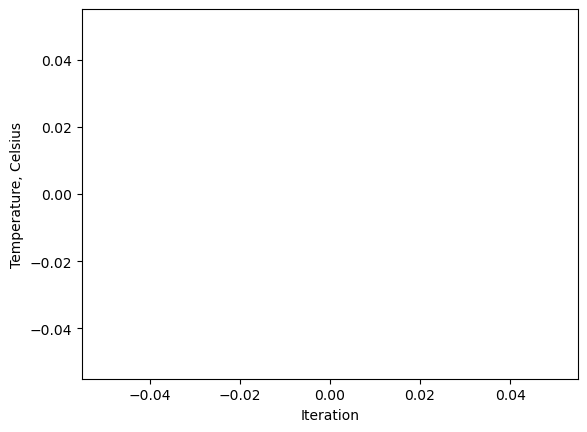

In [7]:
plt.figure()
plt.plot(cam.temperature_change, marker='o')
plt.ylabel('Temperature, Celsius')
plt.xlabel('Iteration')
plt.show()

In [8]:
# Are we getting an image
superk.compact.overall_power(power=0) # this is not altered
dark = cam.take_median_image(100)

Setting overall power level to 0%.


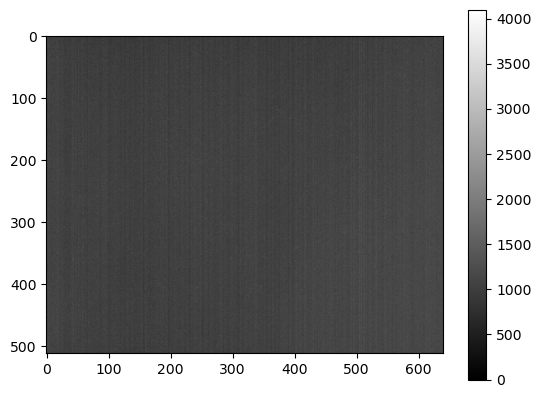

In [9]:
plt.imshow(dark, cmap='gray', vmax=2**12)
plt.colorbar()

# Now remove the cap

Channel 1 wavelength set to: 0.144 nm, amplitude set to: 0.0 %.
Setting overall power level to 0%.


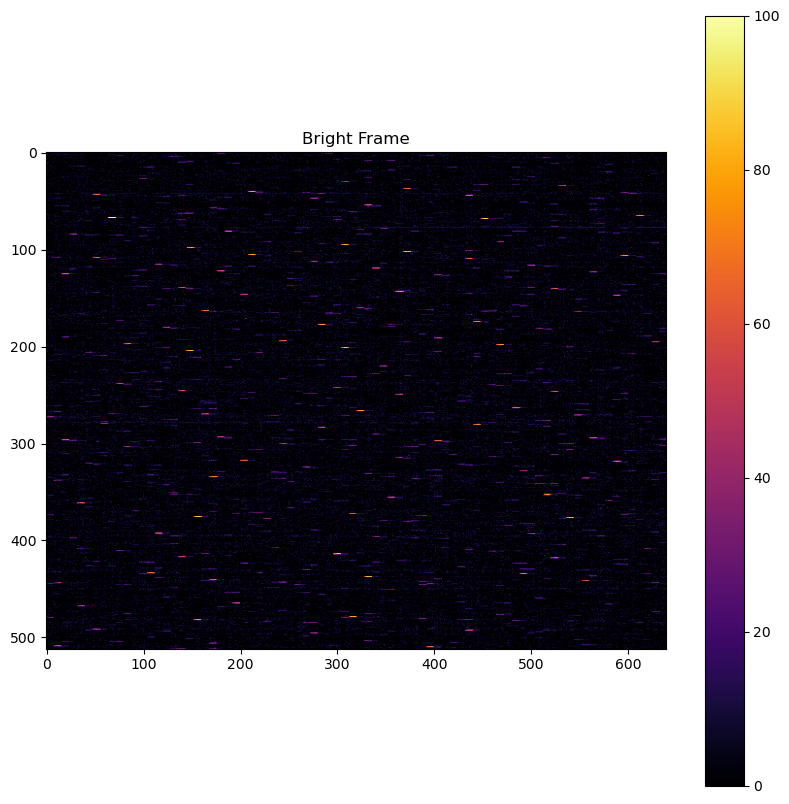

In [12]:
# now a bright
superk.set_channel(1, wavelengths[idx], 100)
superk.compact.overall_power(power=100) # this is not altered
bright = cam.take_median_image(10)

plt.figure(figsize=[10, 10])
plt.title("Bright Frame")
plt.imshow((bright - dark), cmap='inferno', vmax=100, vmin=0)
plt.colorbar()

Determine a window to use on the data. The data inside these pupils should be relatively uniform

C:\Users\EPL User\AppData\Local\Temp\ipykernel_11916\3608701565.py:33: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
C:\Users\EPL User\AppData\Local\Temp\ipykernel_11916\3608701565.py:33: RuntimeWarning: invalid value encountered in divide
  plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r', vmin=-vlim, vmax=vlim)


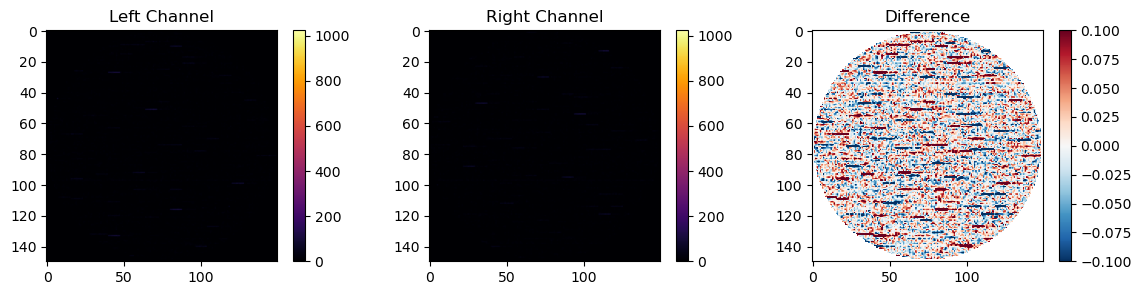

In [14]:
bright, OPM_power_list = cam.take_many_images(10, OPM = S122C)
bright_avg = np.median(bright, axis=0) - dark
bright_avg[bright_avg < 0] = 0

# define subaperture centers
cxr, cyr = 225, 125 # pixel index
cxl, cyl = 225, 315 # pixel index
cut = 75 # crop radius

# defined mask
x = np.linspace(-1, 1, 2*cut)
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r < 1] = 1

left_channel = bright_avg[cxl-cut:cxl+cut,cyl-cut:cyl+cut]
right_channel = bright_avg[cxr-cut:cxr+cut,cyr-cut:cyr+cut]

plt.style.use("default")
plt.figure(figsize=[14,3])
plt.subplot(131)
plt.title("Left Channel")
plt.imshow(mask * left_channel, cmap='inferno', vmin=0, vmax=2**10)
plt.colorbar()
plt.subplot(132)
plt.title("Right Channel")
plt.imshow(mask * right_channel, cmap='inferno', vmin=0, vmax=2**10)
plt.colorbar()
plt.subplot(133)
plt.title("Difference")
vlim = 1e-1
plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
plt.colorbar()
plt.show()

In [15]:
print(OPM_power_list)

[-1.57263162e-08, -1.43930663e-08, -1.44536694e-08, -1.49990935e-08, -1.51202997e-08, -1.54233017e-08, -1.57263162e-08, -1.46203325e-08, -1.43627652e-08, -1.39537022e-08]


Next we initialize the rotation stages

In [ ]:
psg_stg = derpy.PSGRotationStage()
psa_stg = derpy.PSARotationStage()

The following will illustrate the construction of an object that is capable of tracking the state of Derp, which is critical to update throughout the experiment.

In [ ]:
from derpy import Experiment, forward_calibrate, forward_simulate

We begin by initializing the Experiment object with our various devices

In [ ]:
air_test = Experiment(cam, psg_stg, psa_stg, superk, # hardware interfaces
                      dark=dark, # reference frames
                      cut=cut, cxl=cxl, cxr=cxr, cyl=cyl, cyr=cyr) # crop parameters

Next we invoke the measurement method, which takes step sizes for the PSG and PSA, and the number of steps to take. The images and angular steps are saved internally.

In [ ]:
ANGULAR_STEP = 3.6 # deg
ANGULAR_RATIO = 2.5 # deg
N_MEASUREMENTS = 50

psg_step = ANGULAR_STEP
psa_step = ANGULAR_STEP * ANGULAR_RATIO

print("End angle PSG: ", ANGULAR_STEP * N_MEASUREMENTS)
print("End angle PSA: ", ANGULAR_STEP * ANGULAR_RATIO * N_MEASUREMENTS) 

In [ ]:
air_test.measurement(psg_step, psa_step, N_MEASUREMENTS)

Here's just a plot of the observed power

In [ ]:
plt.style.use("bmh")

plt.title("Initial calibration run")
P_ref_0 = air_test.mean_power_left[0] + air_test.mean_power_right[0]
P_ref_l = np.asarray(air_test.mean_power_left) + np.asarray(air_test.mean_power_right)
P_ref = P_ref_0 / P_ref_l

plt.plot(air_test.psg_positions_relative, air_test.mean_power_left * P_ref, label='left', marker='o')
plt.plot(air_test.psg_positions_relative, air_test.mean_power_right * P_ref, label='right', marker='o')
plt.plot(air_test.psg_positions_relative, P_ref_l, label='total', marker='o')
plt.legend()
plt.ylabel('Power')
plt.xlabel('PSG Angle')

Now we feed the calibration method our guess `x_model` and the experiment.

In [ ]:
x_model =[
    0, # starting_angle_psg_pol
    np.random.random(), # starting_angle_psg_wvp
    np.pi/2, # retardance_psg_wvp
    0, # starting_angle_psa_pol
    np.random.random(), # starting_angle_psa_wvp
    np.pi/2 # retardance_psa_wvp
]

results = minimize(forward_calibrate, x0=x_model, args=(air_test, 'left'))

In [ ]:
print(np.degrees(results.x))

After getting the calibrated parameters we can plot how well the fit matches the data

In [ ]:
simulated_power = forward_simulate(results.x, air_test, 'left')

In [ ]:
psg_angles = air_test.psg_positions_relative
plt.plot(psg_angles, simulated_power / np.max(simulated_power), label='simulated')
plt.plot(psg_angles, air_test.mean_power_left / np.max(air_test.mean_power_left), label='measured', linestyle="None", marker='o')
plt.legend()
plt.xlabel('PSG Angle, deg')
plt.ylabel('Normalized Power')

That's pretty good! If we look at the calibrated angles we can see that the results aren't too insane. More notably, the retardance values are near 90 degrees, which is what we expect for a quarter waveplate

Now that we have calibrated where our polarimeter has been, we can update the internal angles. This is important for the next step, which is to measure the Mueller matrix of air.

update them with the calibrated values

In [ ]:
def calibrate_experiment(x, experiment):

    experiment.psg_pol_angle = x[0]
    experiment.psg_starting_angle = np.degrees(x[1])
    experiment.psg_wvp_ret = x[2]
    experiment.psa_pol_angle = x[3]
    experiment.psa_starting_angle = np.degrees(x[4])
    experiment.psa_wvp_ret = x[5]

    return experiment

In [ ]:
air_test_calibrated = calibrate_experiment(results.x, air_test)

First as a sanity check, we can perform a measurement on the calibrated data.

In [ ]:
from derpy.data_reduction import measure_from_experiment

In [ ]:
M = measure_from_experiment(air_test_calibrated, channel='both')

In [ ]:
def plot_square(x, n=4, vmin=None,vmax=None, title=None, scale_offdiagonal=1/10, mask=None):
    k = 1
    plt.figure(figsize=[11,8.5])
    if title is not None:
        plt.suptitle(title, fontsize=24)
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            if mask is not None:
                x_mean = np.mean(x[..., i, j][mask==1])
                x_meansub = x[..., i, j] - x_mean
                plt.title(f'{x_mean:.2f}'+r'$\pm$'+f'{np.std(x_meansub[mask==1]):.4f}')

                if i == j:
                    plt.imshow(x[..., i, j] * mask, vmin=vmin, vmax=vmax, cmap='RdBu_r')
                else:
                    plt.imshow(x[..., i, j] * mask, vmin=vmin * scale_offdiagonal, vmax=vmax * scale_offdiagonal, cmap='PuOr_r')

            else:
                if i == j:
                    plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax, cmap='RdBu_r')
                else:
                    plt.imshow(x[..., i, j], vmin=vmin * scale_offdiagonal, vmax=vmax * scale_offdiagonal, cmap='PuOr_r')

            plt.colorbar()
            plt.xticks([],[])
            plt.yticks([],[])
            k += 1
    plt.show()

In [ ]:
plt.style.use("default")

# define a mask to protect us from the big dots
mask_data = np.zeros_like(M[:,:,0,0])
mask_data[r < 0.8] = 1


plot_square(M / M[..., 0, 0, None, None], title="Dual Channel I-inversion", vmin=-1.1, vmax=1.1, scale_offdiagonal=1/10, mask=mask_data)

Good to see that the calibration is working. Now we can actually measure the Mueller matrix of air.

In [ ]:
air_measure = Experiment(cam, psg_stg, psa_stg, dark=dark, cut=cut,
                         cxl=cxl, cxr=cxr, cyl=cyl, cyr=cyr)

In [ ]:
ANGULAR_STEP = 3.6
ANGULAR_RATIO = 2.5
N_MEASUREMENTS = 100

psg_step = ANGULAR_STEP
psa_step = ANGULAR_STEP * ANGULAR_RATIO

air_measure.measurement(psg_step, psa_step, N_MEASUREMENTS)

In [ ]:
prior_psg_motion = air_test_calibrated.psg_positions_relative[-1]
prior_psa_motion = air_test_calibrated.psa_positions_relative[-1]

In [ ]:
plt.style.use("bmh")
plt.figure(figsize=[7,4])
plt.title("Measurement")

P_ref_0 = air_measure.mean_power_left[0] + air_measure.mean_power_right[0]
P_ref_l = np.asarray(air_measure.mean_power_left) + np.asarray(air_measure.mean_power_right)
P_ref = P_ref_0 / P_ref_l
plt.plot(air_measure.psg_positions_relative, air_measure.mean_power_left, label='left', marker='o')
plt.plot(air_measure.psg_positions_relative, air_measure.mean_power_right, label='right', marker='o')
plt.plot(air_measure.psg_positions_relative, P_ref_l, label='total', marker='o')
plt.legend()
plt.ylabel('Power')
plt.xlabel('PSG Angle')

In [ ]:
BAD_FRAMES = []
mask_bad_frames = np.ones_like(air_measure.mean_power_left)
mask_bad_frames[BAD_FRAMES] = 0

Now we need to construct the updated calibration parameters. For now, do so manually

In [ ]:
air_measure.psg_pol_angle = results.x[0]
air_measure.psg_starting_angle = np.degrees(results.x[1]) + prior_psg_motion
air_measure.psg_wvp_ret = results.x[2]
air_measure.psa_pol_angle = results.x[3]
air_measure.psa_starting_angle = np.degrees(results.x[4]) + prior_psa_motion
air_measure.psa_wvp_ret = results.x[5]

In [ ]:
from derpy import measure_from_experiment
M_measure = measure_from_experiment(air_measure, channel="boop", frame_mask=mask_bad_frames)

In [ ]:
plt.style.use("default")
mask_aperture = np.zeros_like(M_measure[:,:,0,0])
mask_aperture[r < 0.7] = 1

# u = np.linspace(-1,1,mask_aperture.shape[0])
# u, v = np.meshgrid(u, u)
# xshift, yshift = 0.25, 0.2
# rho = np.sqrt((u - xshift)**2 + (v-yshift)**2)
# mask_aperture[rho < 0.1] = 0


# mask_aperture[r < 0.4] = 0
plot_square(M_measure / M_measure[..., 0, 0, None, None], title="I Measurement", scale_offdiagonal=1/10, mask=mask_aperture, vmin=-1, vmax=1)

In [ ]:
# Get the retardance pupil
from katsu.mueller import decompose_retarder
Mr = decompose_retarder(M_measure * (mask_aperture[..., None, None] + 1e-10))

def retardance_from_retarder(M):

    trace_M = M[..., 0, 0] + M[..., 1, 1] + M[..., 2, 2] + M[..., 3, 3]
    retardance = ((trace_M / 2) - 1)

    return retardance

retpupil = retardance_from_retarder(Mr)
retpupil -= np.mean(retpupil[mask_aperture==1])

plt.figure()
plt.title(fr"$\sigma=${np.std(retpupil[mask_aperture==1] / (2*np.pi) * 1550):.4f}nm")
plt.imshow(retpupil * mask_aperture / mask_aperture / (2 * np.pi) * 1550, cmap='coolwarm', vmax=None)
plt.colorbar(label="Retardance Residuals, nm")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

In [ ]:
from derpy import q_measure_from_experiment

# Q data reduction

In [ ]:
M_measure = q_measure_from_experiment(air_measure)

In [ ]:
plt.style.use("default")
plot_square(M_measure * mask[..., None, None], vmin=-1, vmax=1, title="Q Measurement", mask=mask_data, scale_offdiagonal=1)

In [ ]:
from derpy import q_continuum_from_experiment

In [ ]:
M_measure = q_continuum_from_experiment(air_measure)

In [ ]:
plot_square(M_measure * mask[..., None, None] / M_measure[..., 0, 0, None, None], title="Q Continuum", vmin=-1, vmax=1, mask=mask_data, scale_offdiagonal=1)

# Try writing functionality

In [ ]:
from importlib import reload
import derpy.writing
reload(derpy.writing)
from derpy.writing import write_experiment

In [ ]:
from derpy.writing import write_experiment

write_experiment(air_measure, "air_measure_test")

In [ ]:
from derpy.writing import read_experiment
air_measure_reload = read_experiment("air_measure_test.msgpack")

In [ ]:
M = measure_from_experiment(air_measure_reload)
plot_square(M / M[..., 0, 0, None, None], vmin=-1, vmax=1)

# Try the FITS Writer

In [ ]:
from importlib import reload
import derpy.writing
reload(derpy.writing)
from derpy.writing import save_experiment_data

save_experiment_data(air_measure_reload, "air_measure_test_data")

# Try to process out Dark Current

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2, fftshift

filtered_imgs = []

for img in air_measure.images:
    filtered_imgs.append(gaussian_filter(img, 2))

In [ ]:
sample = img

fftiimg = fft2(sample)

xshape = sample.shape[0]
yshape = sample.shape[1]
ratio = yshape / xshape

x = np.linspace(-1, 1, sample.shape[0])
y = np.linspace(-1 * ratio, 1 *ratio, sample.shape[1])

sigma = 0.1 
x, y = np.meshgrid(y, x)
fftmask = np.exp(-(x**2 + y**2) / (2 * sigma))
fftmask = np.zeros_like(sample)
fftmask[x**2 + y**2 < 0.5] = 1

plt.figure
plt.imshow(np.log10(np.abs(fftshift(fftiimg))) * fftmask)
plt.colorbar()
plt.show()

recombine = np.abs(ifft2(fftshift(fftiimg) * fftmask))
plt.figure()
plt.subplot(121)
plt.title("Before Processing")
plt.imshow(sample, cmap='inferno')
plt.subplot(122)
plt.title("After Processing")
plt.imshow(recombine, cmap='inferno')
plt.show()

In [ ]:
for img in air_measure.images:

    fftiimg = fftshift(fft2(img))
    mask_img = fftmask * fftiimg
    filtered_imgs.append((np.abs(ifft2(mask_img))))

In [ ]:
air_measure_reload.images = filtered_imgs
M_update = measure_from_experiment(air_measure_reload, channel="both")

In [ ]:
fftmask.shape

In [ ]:
plt.imshow(filtered_imgs[0], cmap='inferno')
plt.colorbar()

bright_avg = recombine
cxr, cyr = 165, 380
cxl, cyl = 165, 310
cut = 34

x = np.linspace(-1, 1, 2*cut)
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r < 1] = 1

left_channel = bright_avg[cxl-cut:cxl+cut,cyl-cut:cyl+cut]
right_channel = bright_avg[cxr-cut:cxr+cut,cyr-cut:cyr+cut]

plt.style.use("default")
plt.figure(figsize=[14,3])
plt.subplot(131)
plt.title("Left Channel")
plt.imshow(mask * left_channel, cmap='inferno', vmin=0, vmax=2**10)
plt.colorbar()
plt.subplot(132)
plt.title("Right Channel")
plt.imshow(mask * right_channel, cmap='inferno', vmin=0, vmax=2**10)
plt.colorbar()
plt.subplot(133)
plt.title("Difference")
vlim = 1e-1
plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
plt.colorbar()
plt.show()

In [ ]:
air_measure_reload.images = filtered_imgs

In [ ]:
M_lowpass = measure_from_experiment(air_measure_reload)

In [ ]:
plot_square(M_lowpass / M_lowpass[..., 0, 0, None, None] * mask_aperture[..., None, None], vmin=-1, vmax=1)

In [ ]:
plt.imshow(filtered_imgs[0], cmap='inferno')
plt.colorbar()

bright_avg = filtered_imgs[0]
cxr, cyr = 165, 380
cxl, cyl = 165, 310
cut = 34

x = np.linspace(-1, 1, 2*cut)
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r < 1] = 1

left_channel = bright_avg[cxl-cut:cxl+cut,cyl-cut:cyl+cut]
right_channel = bright_avg[cxr-cut:cxr+cut,cyr-cut:cyr+cut]

plt.style.use("default")
plt.figure(figsize=[14,3])
plt.subplot(131)
plt.title("Left Channel")
plt.imshow(mask * left_channel, cmap='inferno', vmin=0, vmax=2**10)
plt.colorbar()
plt.subplot(132)
plt.title("Right Channel")
plt.imshow(mask * right_channel, cmap='inferno', vmin=0, vmax=2**10)
plt.colorbar()
plt.subplot(133)
plt.title("Difference")
vlim = 1e-1
plt.imshow((left_channel / left_channel.max() - right_channel / right_channel.max()) / mask, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
plt.colorbar()
plt.show()